In [246]:
# imports
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
##%matplotlib inline
from ipywidgets import *

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# if cloning repo and running on jupyter, only need to run this cell
# load dataset using pickle

datapath = os.path.join(os.getcwd(), 'datasets', 'Monkey Datasets', 'co_feats20.pkl') # run this line if in jupyter/cloned repo
print(datapath)
# datapath = os.path.join(os.getcwd(),'Monkey_Datasets', 'co_feats32.pkl') # run this line if colab
#datapath = "datasets\Monkey Datasets"
with open(datapath, 'rb') as f:
	data = pickle.load(f)
# quick lil dataframe to make it visual
dfs = []
for key in data.keys():
	dfs.append(pd.DataFrame(data[key]))
dfs = pd.concat(dfs, axis=1, keys=data.keys())
# group center out movements and show average trajectory, as well as corresponding neural data?

c:\Files\UM\BMIHackathon\datasets\Monkey Datasets\co_feats20.pkl


In [247]:

reachpositions = np.unique(data['targetPosition'], axis=0)

print(reachpositions)
reachpositions_interested = np.vstack((reachpositions[2,:], reachpositions[6,:]))
reachpositions_interested = reachpositions
print(reachpositions_interested)

grouped = {'neural':[], 'behavior':[]}
for position in reachpositions_interested:

	#get all trials for this target positions
	trials = np.unique(data['trialNumber'][np.argwhere((data['targetPosition'] == position).all(axis=1))])
	lens = np.stack([np.sum(data['trialNumber'] == trial) for trial in trials])

	# we need to align our trials since they are usually different lengths.
	# There are better ways to do this (time warping, etc.), but here we'll just truncate to the shortest trial of the group
	behavior = np.zeros((len(lens), np.min(lens), 6))
	neural = np.zeros((len(lens), np.min(lens), 96))
	for i, trial in enumerate(trials):
		behavior[i,:,:] = data['behavior'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]
		neural[i,:,:] = data['neural'][(data['trialNumber'] == trial)[:,0],:][0:np.min(lens),:]

	grouped['behavior'].append(behavior)
	grouped['neural'].append(neural)

[[0.2 0.2]
 [0.2 0.5]
 [0.2 0.8]
 [0.5 0.2]
 [0.5 0.5]
 [0.5 0.8]
 [0.8 0.2]
 [0.8 0.5]
 [0.8 0.8]]
[[0.2 0.2]
 [0.2 0.5]
 [0.2 0.8]
 [0.5 0.2]
 [0.5 0.5]
 [0.5 0.8]
 [0.8 0.2]
 [0.8 0.5]
 [0.8 0.8]]


In [248]:
neural_list = [np.concatenate(array, axis=0) for array in grouped['neural']]
print(neural_list[0].shape)
kinematic_ends = []
for kinematic_trial in neural_list:
	if(kinematic_ends != []):
		kinematic_ends.append(kinematic_trial.shape[0]+kinematic_ends[-1])
	else:
		kinematic_ends.append(kinematic_trial.shape[0])
neural_data = np.concatenate(neural_list, axis=0)
print(neural_data.shape)

#clamp out outliers
neural_data_new = []
for i in range(neural_data.shape[0]):
	flag = False
	trial = neural_data[i,:]
	for j in trial:
		if(j<=30):
			flag = True
	if(flag):
		neural_data_new.append(trial)
neural_data_new = np.array(neural_data_new)		
neural_data = neural_data_new
print(neural_data.shape)
print(kinematic_ends)

#normalize
normalized_neural_data = (neural_data - neural_data.min()) / (np.ptp(neural_data))
neural_data = normalized_neural_data
print(neural_data.shape)

(4399, 96)
(58852, 96)
(58851, 96)
[4399, 10223, 16106, 21202, 41857, 44287, 48715, 53499, 58852]
(58851, 96)


In [249]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split

class VAE(nn.Module):

    def __init__(self, input_dim=96, hidden_dim=50, latent_dim=30):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            #nn.Dropout(p=0.7, inplace=False),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    
def loss_function(x, x_hat, mean, log_var,epoch):
    klloss = torch.nn.KLDivLoss()
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    kl_divergence_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    #kl_divergence_loss_torch = klloss(mean, torch.zeros(mean.shape))
    if(epoch >= 0):
        output_loss = reproduction_loss + 0.1*kl_divergence_loss
		
        return output_loss, kl_divergence_loss, reproduction_loss
    else:
        output_loss = reproduction_loss + 0.1*kl_divergence_loss
        return output_loss, kl_divergence_loss*0, reproduction_loss

def train(model, optimizer, epochs, train_loader,test_loader, batch_size_train,batch_size_test):
    model.train()
    metric_loss_train=[]
    metric_loss_test=[]
    metric_klloss_train=[]
    metric_klloss_test=[]
    metric_rploss_train=[]
    metric_rploss_test=[]

    for epoch in range(epochs):
        model.train()

        overall_train_loss = 0
        overall_test_loss = 0
        overall_train_klloss = 0
        overall_test_klloss = 0
        overall_train_rploss = 0
        overall_test_rploss = 0

        for id,x in enumerate(train_loader):
            x = x.float()

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss,kl_loss,repro_loss = loss_function(x, x_hat, mean, log_var,epoch)
            
            overall_train_loss += loss.item()
            overall_train_klloss += kl_loss.item()
            overall_train_rploss += repro_loss.item()
            
            (loss/batch_size_train).backward()
            optimizer.step()
		
        

        model.eval()
        with torch.no_grad():
            for id,x in enumerate(test_loader):
                x = x.float()
                x_hat, mean, log_var = model(x)
                loss,kl_loss,repro_loss = loss_function(x, x_hat, mean, log_var,epoch)
                overall_test_loss += loss.item()
                overall_test_klloss += kl_loss.item()
                overall_test_rploss += repro_loss.item()

        metric_loss_train.append(overall_train_loss/(id*batch_size_train))
        metric_loss_test.append(overall_test_loss/(id*batch_size_test))
        metric_klloss_train.append(overall_train_klloss/(id*batch_size_train))
        metric_klloss_test.append(overall_test_klloss/(id*batch_size_test))
        metric_rploss_train.append(overall_train_rploss/(id*batch_size_train))
        metric_rploss_test.append(overall_test_rploss/(id*batch_size_test))


        print("\tEpoch", epoch + 1, "\tAverage Train Loss: ", overall_train_loss/len(train_loader), "\tAverage Test Loss: ", overall_test_loss/len(test_loader))
        print("\tEpoch", epoch + 1, "\tAverage Train KL Loss: ", overall_train_klloss/len(train_loader), "\tAverage Test KL Loss: ", overall_test_klloss/len(test_loader))
        print("\tEpoch", epoch + 1, "\tAverage Train RP Loss: ", overall_train_rploss/len(train_loader), "\tAverage Test RP Loss: ", overall_test_rploss/len(test_loader))
        print(len(train_loader))
        print(len(test_loader))
    return metric_loss_train,metric_loss_test,metric_klloss_train,metric_klloss_test,metric_rploss_train,metric_rploss_test


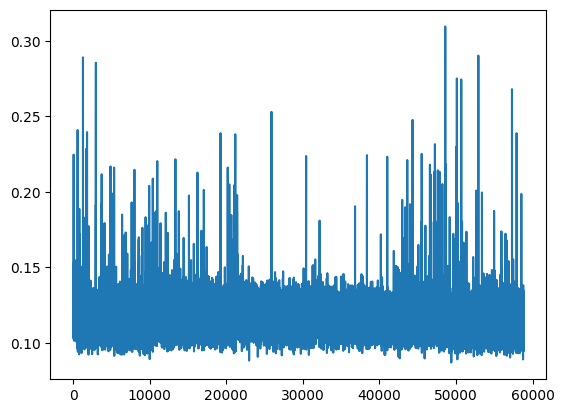

In [250]:
train_percentage = 0.7
np.random.seed(12345)
plt.plot(neural_data.mean(axis= 1))


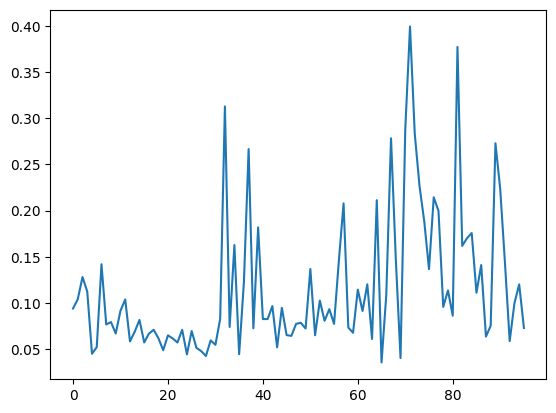

In [251]:
plt.plot(neural_data.mean(axis= 0))

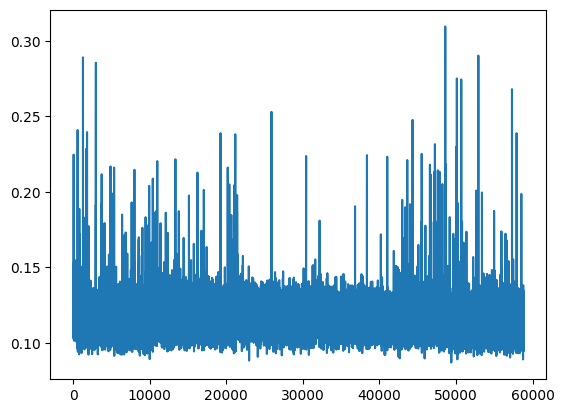

In [252]:
#np.random.shuffle(neural_data)
plt.plot(neural_data.mean(axis= 1))


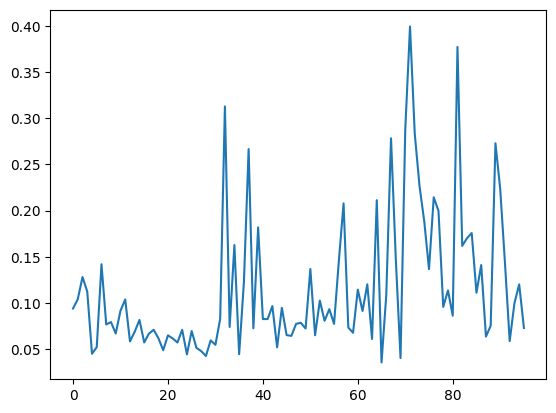

In [253]:
plt.plot(neural_data.mean(axis= 0))

In [254]:

train_set = neural_data[:int(neural_data.shape[0] * train_percentage), :]
test_set = neural_data[int(neural_data.shape[0] * train_percentage):, :]

batch_size_train = 128
batch_size_test = 512

trainSetLoader = DataLoader(train_set,
                             batch_size = batch_size_train,
                             shuffle=True)
testSetLoader = DataLoader(test_set,
                             batch_size = batch_size_test,
                             shuffle=False)

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mltrain,mltest,mkltrain,mkltest,mrptrain,mrptest = train(model, optimizer, 200, trainSetLoader, testSetLoader,batch_size_train,batch_size_test)


	Epoch 1 	Average Train Loss:  0.030320500161047585 	Average Test Loss:  0.00244317018826093
	Epoch 1 	Average Train KL Loss:  0.11439031436576606 	Average Test KL Loss:  0.013608757938657488
	Epoch 1 	Average Train RP Loss:  0.01888146873412405 	Average Test RP Loss:  0.0010822943494921283
322
35
	Epoch 2 	Average Train Loss:  0.0011934540245352278 	Average Test Loss:  0.001408284150862268
	Epoch 2 	Average Train KL Loss:  0.0014855710801130496 	Average Test KL Loss:  0.003240971905844552
	Epoch 2 	Average Train RP Loss:  0.0010448969198862288 	Average Test RP Loss:  0.0010841869383252092
322
35
	Epoch 3 	Average Train Loss:  0.0010907118937567525 	Average Test Loss:  0.001204137404316238
	Epoch 3 	Average Train KL Loss:  0.000449802379430451 	Average Test KL Loss:  0.001220341239656721
	Epoch 3 	Average Train RP Loss:  0.0010457316578744754 	Average Test RP Loss:  0.001082103283676718
322
35
	Epoch 4 	Average Train Loss:  0.0010671101494978605 	Average Test Loss:  0.00114969728248459

<function matplotlib.pyplot.show(close=None, block=None)>

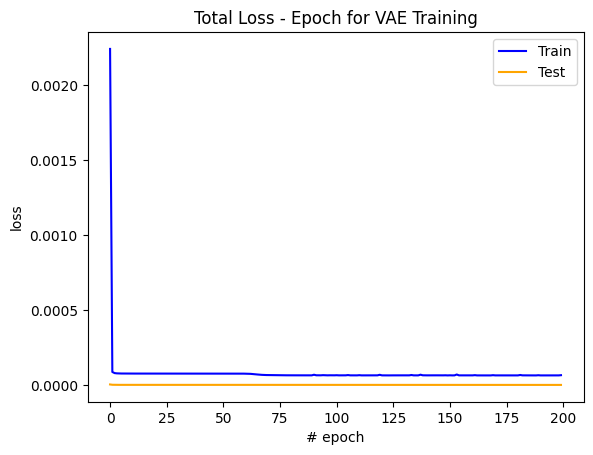

In [255]:
plt.plot(mltrain,color='blue')
plt.plot(mltest,color='orange')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.title('Total Loss - Epoch for VAE Training')
plt.legend(['Train','Test'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

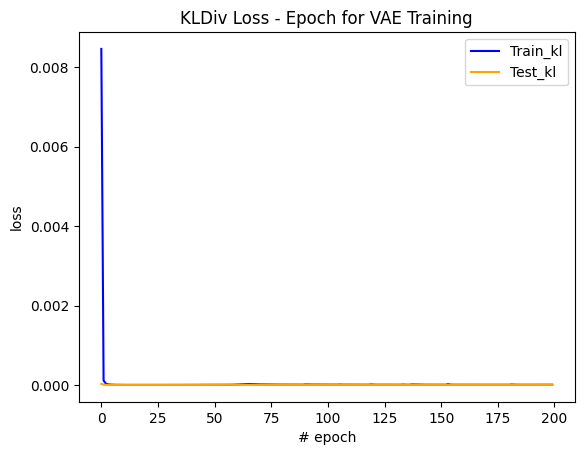

In [256]:
plt.plot(mkltrain,color='blue')
plt.plot(mkltest,color='orange')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.title('KLDiv Loss - Epoch for VAE Training')
plt.legend(['Train_kl','Test_kl'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

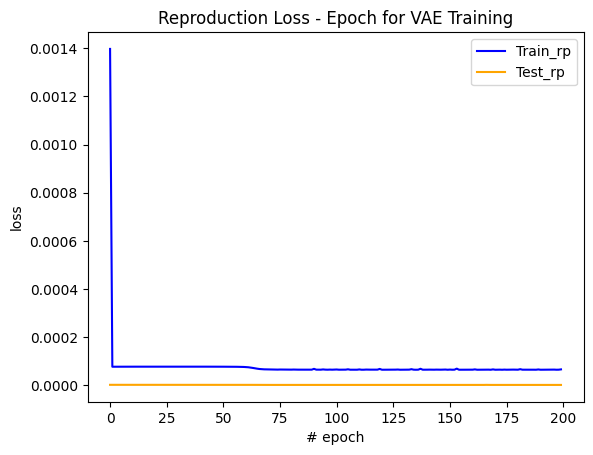

In [257]:
plt.plot(mrptrain,color='blue')
plt.plot(mrptest,color='orange')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.title('Reproduction Loss - Epoch for VAE Training')
plt.legend(['Train_rp','Test_rp'])
plt.show

torch.Size([4399, 2])


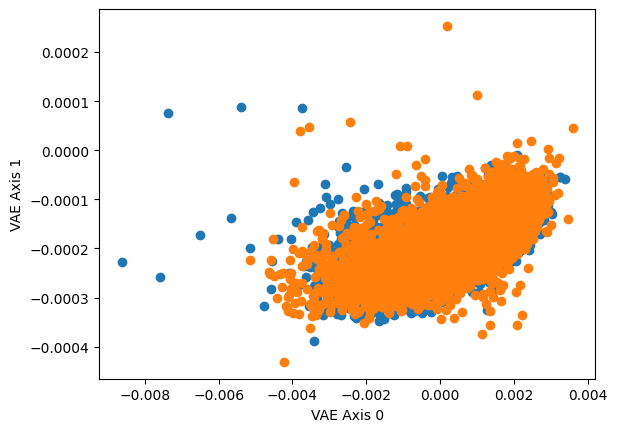

In [260]:
def given_index_return_split(index1,index2,endpoints,data):
    if(index1 != 0):
        data1 = data[endpoints[index1-1]:endpoints[index1]]
    else:
        data1 = data[0:endpoints[index1]]
    data2 = data[endpoints[index2-1]:endpoints[index2]]
    return data1,data2

neural_data_first, neural_data_second = given_index_return_split(0,1,kinematic_ends,neural_data)
#neural_data_first, neural_data_second = reachpositions[2,:], reachpositions[6,:]

vae_out_first_0,vae_out_first_1 = model.encode(torch.tensor(neural_data_first).float())
vae_out_second_0,vae_out_second_1 = model.encode(torch.tensor(neural_data_second).float())
print(vae_out_first_0.shape)
plt.scatter(vae_out_first_0[:,0].detach().numpy(),vae_out_first_0[:,1].detach().numpy())
plt.scatter(vae_out_second_0[:,0].detach().numpy(),vae_out_second_0[:,1].detach().numpy())
plt.xlabel('VAE Axis 0')
plt.ylabel('VAE Axis 1')
plt.show
input_pca_first = vae_out_first_1.detach().numpy()
input_pca_second = vae_out_second_1.detach().numpy()

(array([   18.26582975,    18.26571665,     0.        ,    18.26571665,
            0.        ,     0.        ,    18.26582975,     0.        ,
            0.        ,    18.26571665,     0.        ,     0.        ,
            0.        ,     0.        ,    36.5316595 ,    18.26582975,
            0.        ,     0.        ,     0.        ,     0.        ,
           18.26571665,     0.        ,     0.        ,    18.26582975,
            0.        ,    18.26582975,    36.5314333 ,    18.26582975,
           36.5315464 ,     0.        ,     0.        ,     0.        ,
            0.        ,    18.2657732 ,    18.2657732 ,     0.        ,
           18.2657732 ,     0.        ,    18.2657732 ,     0.        ,
            0.        ,    18.2657732 ,    91.328866  ,    18.2657732 ,
           36.5315464 ,    18.2657732 ,    54.7973196 ,    18.2657732 ,
           18.2657732 ,    91.328866  ,    54.7973196 ,    18.2657732 ,
           36.5316595 ,    73.0629797 ,    18.2657732 ,    54.79

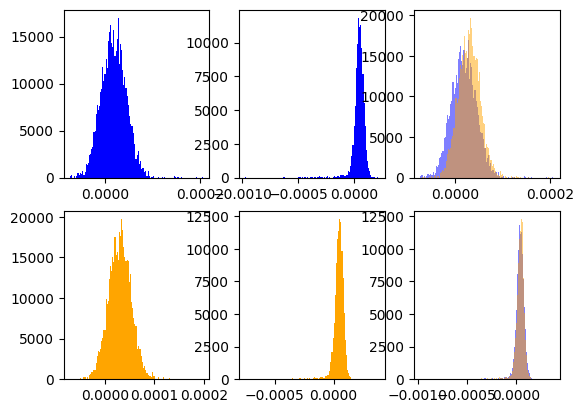

In [259]:

fig,ax  = plt.subplots(2,3)
ax[0,0].hist(input_pca_first[:,0], density=True, bins=120,color='Blue')
ax[1,0].hist(input_pca_second[:,0], density=True, bins=120,color='Orange')
ax[0,1].hist(input_pca_first[:,1], density=True, bins=120,color='Blue')
ax[1,1].hist(input_pca_second[:,1], density=True, bins=120,color='Orange')

ax[0,2].hist(input_pca_first[:,0], density=True, bins=120,color='Blue',alpha=0.5)
ax[0,2].hist(input_pca_second[:,0], density=True, bins=120,color='Orange',alpha=0.5)
ax[1,2].hist(input_pca_first[:,1], density=True, bins=120,color='Blue',alpha=0.5)
ax[1,2].hist(input_pca_second[:,1], density=True, bins=120,color='Orange',alpha=0.5)